In [13]:
import pandas as pd

lol_df = pd.read_csv("data/lol_data.csv")
lol_df
# lol_df = lol_df.drop(["gameId", "creationTime","seasonId"], axis=1)

gameId   creationTime  gameDuration  seasonId  winner  firstBlood  \
0      3326086514  1504279457970          1949         9       1           2   
1      3229566029  1497848803862          1851         9       1           1   
2      3327363504  1504360103310          1493         9       1           2   
3      3326856598  1504348503996          1758         9       1           1   
4      3330080762  1504554410899          2094         9       1           2   
...           ...            ...           ...       ...     ...         ...   
51485  3308904636  1503076540231          1944         9       2           1   
51486  3215685759  1496957179355          3304         9       2           1   
51487  3322765040  1504029863961          2156         9       2           2   
51488  3256675373  1499562036246          1475         9       2           2   
51489  3317333020  1503612754059          1445         9       1           1   

       firstTower  firstInhibitor  firstBaron  firstDragon  ...  \
0               1               1           1            1  ...   
1               1               1           0            1  ...   
2               1               1           1            2  ...   
3               1               1           1            1  ...   
4               1               1           1            1  ...   
...           ...             ...         ...          ...  ...   
51485           2               2           0            2  ...   
51486           1               2           2            2  ...   
51487           2               2           0            1  ...   
51488           2               2           0            2  ...   
51489           1               1           1            2  ...   

       t2_towerKills  t2_inhibitorKills  t2_baronKills  t2_dragonKills  \
0                  5                  0              0               1   
1                  2                  0              0               0   
2                  2                  0              0               1   
3                  0                  0              0               0   
4                  3                  0              0               1   
...              ...                ...            ...             ...   
51485             10                  2              0               4   
51486             11                  7              4               4   
51487             10                  2              0               2   
51488             11                  3              0               1   
51489              1                  0              0               1   

       t2_riftHeraldKills  t2_ban1  t2_ban2  t2_ban3  t2_ban4  t2_ban5  
0                       1      114       67       43       16       51  
1                       0       11       67      238       51      420  
2                       0      157      238      121       57       28  
3                       0      164       18      141       40       51  
4                       0       86       11      201      122       18  
...                   ...      ...      ...      ...      ...      ...  
51485                   0       55       -1       90      238      157  
51486                   1      157       55      119      154      105  
51487                   0      113      122       53       11      157  
51488                   0      154       39       51       90      114  
51489                   0       11      157      141       31       18  

[51490 rows x 61 columns]

In [14]:
# 'gameDuration', 'winner',

# 't[1,2]_champ[1-5]id'
champ_id_cols = [f"t{t}_champ{i+1}id" for t in [1,2] for i in range(5)]

# 't[1-2]_champ[1-5]_sum[1-2]'
champ_sum_cols = [f"t{t}_champ{i+1}_sum{j}" for t in [1,2] for i in range(5) for j in [1,2]]

# 't[1-2]_ban[1-5]'
ban_cols = [f"t{t}_ban{i+1}" for t in [1,2] for i in range(5)]

# 'firstBlood', 'firstTower', 'firstInhibitor','firstBaron', 'firstDragon', 'firstRiftHerald',
first_cols = ['firstBlood', 'firstTower', 'firstInhibitor','firstBaron', 'firstDragon', 'firstRiftHerald']

numerical_cols = [f"t{t}_{item}Kills" for t in [1,2]
                  for item in ["tower", "inhibitor", "baron", "dragon", "riftHerald"]]

category_cols = champ_id_cols + ban_cols + champ_sum_cols + first_cols


In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# one hot encoding
enc = OneHotEncoder(sparse=False)

def prepare(_lol_df, cate_cols, num_cols):
    cate_feat = pd.DataFrame(enc.fit_transform(_lol_df[cate_cols]))
    lol_feat = pd.concat([cate_feat, _lol_df[num_cols]], axis=1)
    label = _lol_df["winner"]
    # x_train, x_test, y_train, y_test
    return train_test_split(lol_feat, label)

In [16]:
x_train, x_test, y_train, y_test = prepare(lol_df, category_cols, numerical_cols)

## Train

In [17]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [18]:
svc = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
ridge = RidgeClassifier()

In [19]:
model_dict = {}

model_names = ["SVM", "KNN", "Random Forest", "Logistic Regression", "Ridge Classifier"]
for name, model in zip(model_names, [svc, knn, rf, lr, ridge]):
    model.fit(x_train, y_train)
    model_dict[name] = model

C:\Users\wanglx\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
pred_dict = {}

for name, model in model_dict.items():
    y_pred = model.predict(x_test)
    pred_dict[name] = y_pred

In [21]:
from sklearn.metrics import f1_score, accuracy_score, precision_score

metric_records = [{"name": name,
                   "f1": f1_score(y_true=y_test, y_pred=y_pred),
                   "accuracy": accuracy_score(y_true=y_test, y_pred=y_pred),
                   "precision": precision_score(y_true=y_test, y_pred=y_pred)
                   }
                  for name, y_pred in pred_dict.items()]
metric_df = pd.DataFrame.from_records(metric_records)
metric_df

name        f1  accuracy  precision
0                  SVM  0.968278  0.967684   0.958919
1                  KNN  0.959736  0.959295   0.957675
2        Random Forest  0.964256  0.963723   0.958460
3  Logistic Regression  0.957176  0.956653   0.953954
4     Ridge Classifier  0.955036  0.954401   0.950015

In [28]:
ax = metric_df.plot(x="name", y=["f1", "accuracy", "precision"], kind="bar",
                    xlabel="Algorithms", ylabel="Metrics", fontsize=15,
                    figsize=(15,10), ylim=(0.9, 1.0), rot=0)

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]

[2 1 1 ... 2 1 2]
[2 1 1 ... 2 1 2]
[2 1 1 ... 2 1 2]
[2 1 1 ... 2 1 2]
[2 1 1 ... 2 1 2]


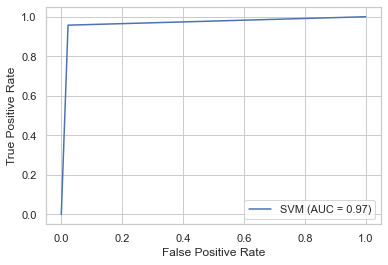

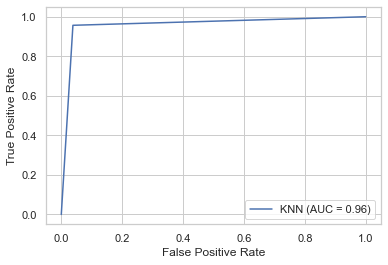

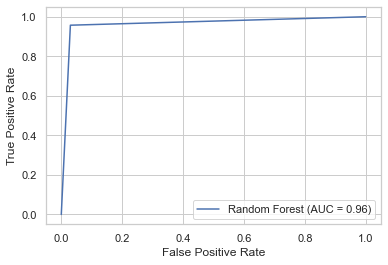

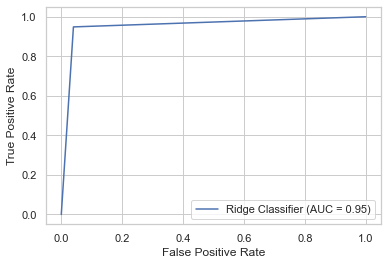

In [68]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt  # doctest: +SKIP

for name, y_pred in pred_dict.items():
    print(y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot()
    # plt.show()      # doctest: +SKIP

    # RocCurveDisplay.from_predictions(y_test, y_pred)

    plt.savefig(f"{name}.png")

